In [1]:
import os
import cv2
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

In [2]:
def draw_found_faces(detected, image, color: tuple):
    for (x, y, width, height) in detected:
        cv2.rectangle(
            image,
            (x, y),
            (x + width, y + height),
            color,
            thickness=2
        )

### Демонстрация работы детектирования лиц используя каскады Хаара

#### Подготовка изображения

In [3]:
path_to_image = 'image.jpg'
original_image = cv2.imread(path_to_image)
# преобразуем изображение в отенки серого
image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

#### Создание каскадных классификаторов

In [4]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
profile_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_profileface.xml")

#### Детектируем лица используя классификаторы

In [5]:
detected_faces = face_cascade.detectMultiScale(image=image, scaleFactor=1.3, minNeighbors=5)
detected_profiles = profile_cascade.detectMultiScale(image=image, scaleFactor=1.3, minNeighbors=5)
# фильтрация
profiles_not_faces = [x for x in detected_profiles if x not in detected_faces]

#### Вывод графики

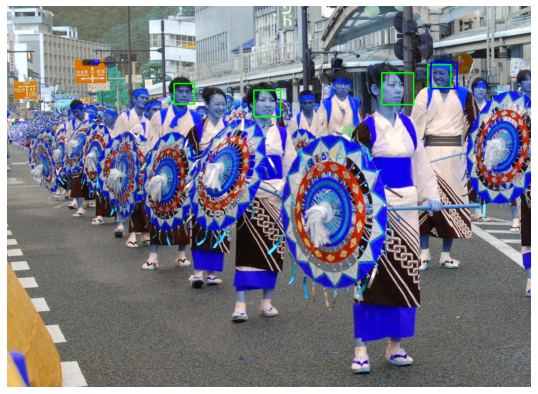

In [6]:
# Выделяем лица на оригинальной картинке
draw_found_faces(detected_faces, original_image, (0, 255, 0)) # RGB - green
draw_found_faces(detected_profiles, original_image, (0, 0, 255)) # RGB - red

# Вывод
fig = plt.figure(figsize=(20, 7))
plt.imshow(original_image)
plt.axis('off')
plt.show()

### Использование каскадов Хаара в методе Виолы-Джонса

#### Подготовка 

In [7]:
# Для детектирования лиц используем каскады Хаара
cv2_base_dir = os.path.dirname(os.path.abspath(cv2.__file__))
haar_model = os.path.join(cv2_base_dir, 'data/haarcascade_frontalface_default.xml')
faceCascade = cv2.CascadeClassifier(haar_model)

recognizer = cv2.face.LBPHFaceRecognizer_create(1,8,8,8,123) 

In [8]:
def get_images(path):
    # Ищем все фотографии и записываем их в image_paths
    image_paths = [os.path.join(path, f) for f in os.listdir(path) if not f.endswith('.happy')]
    
    images = []
    labels = []
    
    for image_path in image_paths:
        # Переводим изображение в черно-белый формат и приводим его к формату массива
        gray = Image.open(image_path).convert('L')
        image = np.array(gray, 'uint8')
        # Из каждого имени файла извлекаем номер человека, изображенного на фото
        subject_number = int(os.path.split(image_path)[1].split(".")[0].replace("subject", ""))
        
        # Определяем области где есть лица
        faces = faceCascade.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
        # Если лицо нашлось добавляем его в список images, а соответствующий ему номер в список labels
        for (x, y, w, h) in faces:
            images.append(image[y: y + h, x: x + w])
            labels.append(subject_number)
            
    return images, labels

path = "yalefaces"
images, labels = get_images(path)

#### Обучение

In [9]:
# Обучаем программу распознавать лица
recognizer.train(images, np.array(labels))

#### Проверка обученной модели

In [10]:
# Создаем список фотографий для распознавания
image_paths = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.happy')]

for image_path in image_paths:
    # Ищем лица на фотографиях
    gray = Image.open(image_path).convert('L')
    image = np.array(gray, 'uint8')
    faces = faceCascade.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in faces:
        # Если лица найдены, пытаемся распознать их
        # Функция  recognizer.predict в случае успешного распознавания возвращает номер и параметр confidence,
        # этот параметр указывает на уверенность алгоритма, что это именно тот человек, чем он меньше, тем больше уверенность
        number_predicted, conf = recognizer.predict(image[y: y + h, x: x + w])

        # Извлекаем настоящий номер человека на фото и сравниваем с тем, что выдал алгоритм
        number_actual = int(os.path.split(image_path)[1].split(".")[0].replace("subject", ""))
        
        if number_actual == number_predicted:
            print("{} is Correctly Recognized with confidence {}".format(number_actual, conf))
        else:
            print("{} is Incorrect Recognized as {}".format(number_actual, number_predicted))

1 is Correctly Recognized with confidence 37.9296056505177
2 is Correctly Recognized with confidence 36.41381875931238
3 is Correctly Recognized with confidence 38.23891137105182
4 is Correctly Recognized with confidence 36.69577466249437
5 is Correctly Recognized with confidence 42.31980058643552
6 is Correctly Recognized with confidence 40.46412416117517
7 is Correctly Recognized with confidence 42.28339070288786
8 is Correctly Recognized with confidence 43.573491989385126
9 is Correctly Recognized with confidence 39.79092572540834
10 is Correctly Recognized with confidence 36.53307851561388
11 is Correctly Recognized with confidence 38.481620677037085
12 is Correctly Recognized with confidence 73.69544300132807
13 is Correctly Recognized with confidence 36.261214553130074
14 is Correctly Recognized with confidence 36.92282585827908
15 is Correctly Recognized with confidence 41.90591573640065


#### Обработка видео

In [39]:
vidcap = cv2.VideoCapture('video.mp4')

In [40]:
fps = vidcap.get(cv2.CAP_PROP_FPS)
frame_count = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
duration = frame_count / fps
vidcap.set(cv2.CAP_PROP_POS_MSEC, 3 * 1000) # optional
success, video_image = vidcap.read()

In [41]:
video_image = cv2.cvtColor(video_image, cv2.COLOR_BGR2GRAY)

In [42]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
profile_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_profileface.xml")

detected_faces = face_cascade.detectMultiScale(image=video_image, scaleFactor=1.3, minNeighbors=5)
detected_profiles = profile_cascade.detectMultiScale(image=video_image, scaleFactor=1.3, minNeighbors=5)
# фильтрация
profiles_not_faces = [x for x in detected_profiles if x not in detected_faces]

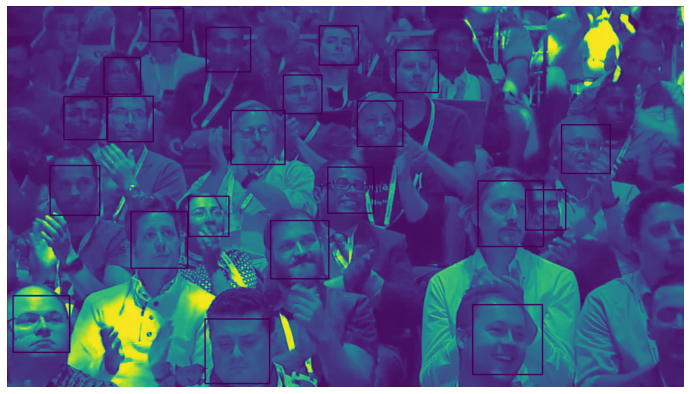

In [44]:
# Выделяем лица на оригинальной картинке
draw_found_faces(detected_faces, video_image, (0, 255, 0)) # RGB - green
draw_found_faces(detected_profiles, video_image, (0, 0, 255)) # RGB - red

# Вывод
fig = plt.figure(figsize=(20, 7))
plt.imshow(video_image)
plt.axis('off')
plt.show()